# Track Comparison

And spatial skill assessments

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('png')
%matplotlib inline

from mikeio import EUMType, ItemInfo
from fmskill import ModelResult, TrackObservation, Connector

## Extract track without having observation as dfs0

In [2]:
fn = '../tests/testdata/NorthSeaHD_and_windspeed.dfsu'
mr = ModelResult(fn, name='HD', item=0)
mr

<DfsModelResultItem> 'HD'
File: ../tests/testdata/NorthSeaHD_and_windspeed.dfsu
- Item: 0: Surface elevation <Surface Elevation> (meter)

In [3]:
fn = '../tests/testdata/altimetry_NorthSea_20171027.csv'
df = pd.read_csv(fn, index_col=0, parse_dates=True)

In [4]:
o1 = TrackObservation(df, item=2, name='alti')
o1.itemInfo = ItemInfo(EUMType.Surface_Elevation)    # if TrackObservation is created with a df, itemInfo needs to be added manually

c:\users\jem\source\fmskill\fmskill\utils.py:38: UserWarning: Time axis has duplicate entries. Now adding milliseconds to non-unique entries to make index unique.
  warnings.warn(


In [5]:
con = Connector(o1, mr)
con

<Connector> with 
 -<TrackConnector> obs=alti(n=1115) :: model=HD

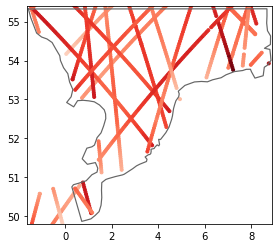

In [6]:
con.plot_observation_positions();

In [7]:
cc = con.extract()

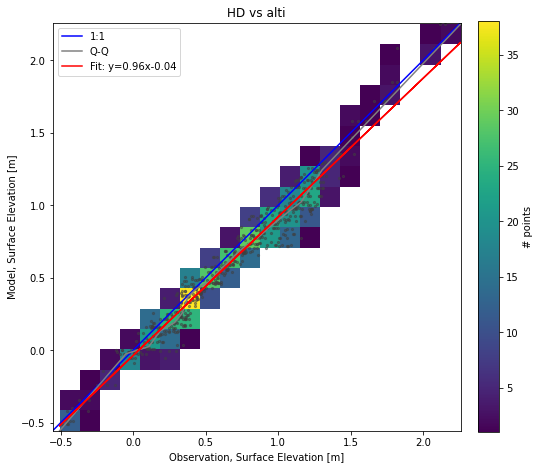

In [8]:
cc['alti'].scatter()

## Extract track from dfs0
ModelResult is now a dfs0

In [9]:
fn = '../tests/testdata/NorthSeaHD_extracted_track.dfs0'
mr = ModelResult(fn, name='HD', item=2)
mr.dfs

<mikeio.Dfs0>
Timeaxis: TimeAxisType.CalendarNonEquidistant
Items:
  0:  Longitude <Undefined> (undefined)
  1:  Latitude <Undefined> (undefined)
  2:  Model_surface_elevation <Undefined> (undefined)
  3:  Model_wind_speed <Undefined> (undefined)

In [10]:
mr.dfs.read()

<mikeio.Dataset>
Dimensions: (1115,)
Time: 2017-10-26 04:37:37 - 2017-10-30 20:54:47
-- Non-equidistant calendar axis --
Items:
  0:  Longitude <Undefined> (undefined)
  1:  Latitude <Undefined> (undefined)
  2:  Model_surface_elevation <Undefined> (undefined)
  3:  Model_wind_speed <Undefined> (undefined)

In [11]:
fn = '../tests/testdata/altimetry_NorthSea_20171027.csv'
df = pd.read_csv(fn, index_col=0, parse_dates=True)
o1 = TrackObservation(df, item=2, name='alti')

c:\users\jem\source\fmskill\fmskill\utils.py:38: UserWarning: Time axis has duplicate entries. Now adding milliseconds to non-unique entries to make index unique.
  warnings.warn(


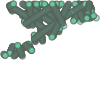

In [12]:
o1.geometry

In [13]:
con = Connector(o1, mr)

In [14]:
cc = con.extract()

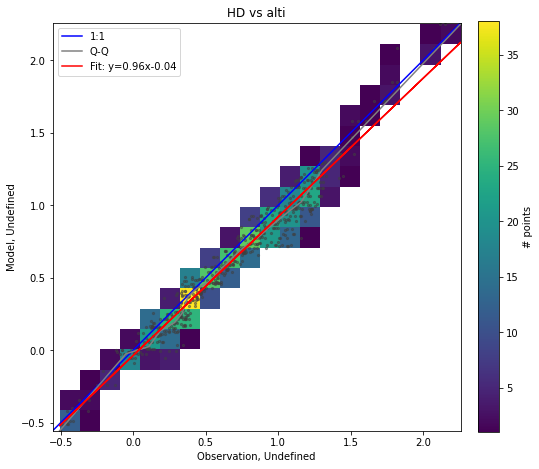

In [15]:
cc['alti'].scatter()

## Spatial skill

Load model, load observation, add observation to model and extract.

In [16]:
fn = '../tests/testdata/NorthSeaHD_and_windspeed.dfsu'
mr = ModelResult(fn, name='HD', item=0)
fn = '../tests/testdata/altimetry_NorthSea_20171027.csv'
df = pd.read_csv(fn, index_col=0, parse_dates=True)
o1 = TrackObservation(df, item=2, name='alti')
con = Connector(o1, mr)
cc = con.extract()

c:\users\jem\source\fmskill\fmskill\utils.py:38: UserWarning: Time axis has duplicate entries. Now adding milliseconds to non-unique entries to make index unique.
  warnings.warn(


Get metrics binned by a regular spatial grid, returns xarray Dataset

In [17]:
ss = cc.spatial_skill(metrics=['bias'])

In [18]:
ss.ds['n']

<xarray.DataArray 'n' (y: 5, x: 5)>
array([[ 3, 17,  0,  0,  0],
       [ 0, 50,  9,  0,  0],
       [ 0, 36, 51,  0,  0],
       [14, 72, 33, 15, 28],
       [37, 83,  0, 20, 76]])
Coordinates:
  * y            (y) float64 50.6 51.66 52.7 53.75 54.8
  * x            (x) float64 -0.436 1.543 3.517 5.492 7.466
    observation  <U4 'alti'
Attributes:
    long_name:  Number of observations
    units:      -

Plot using xarray - convenient methods coming soon!

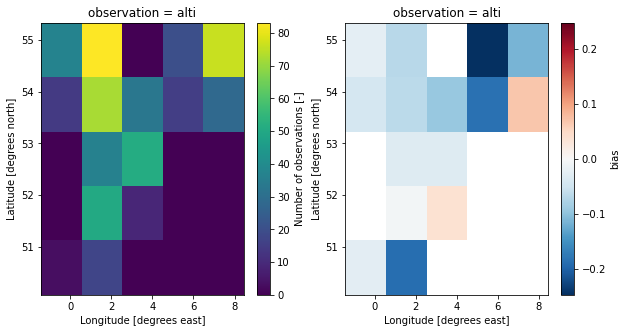

In [19]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize = (10, 5))
ss.plot('n', ax=axes[0])
ss.plot('bias', ax=axes[1]);

## Minimum number of observations

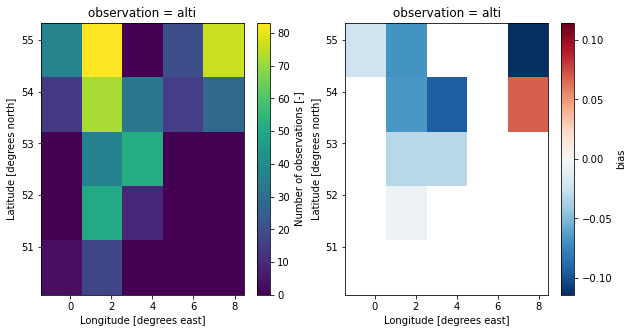

In [20]:
ss = cc.spatial_skill(metrics=['bias'], n_min=25)
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))
ss.plot('n', ax=axes[0])
ss.plot('bias', ax=axes[1]);

## Multiple bins - spatial skill for water level categories

Add water level category to comparer's all_df.

In [21]:
all_df = cc.all_df
all_df['water level'] = 'high'
all_df.loc[all_df['mod_val']<0, 'water level'] = 'low'


Pass custom df with water level category to .spatial_skill and select for 'by'.

In [22]:
ss = cc.spatial_skill(by=['water level'],metrics=['bias'],n_min=5)

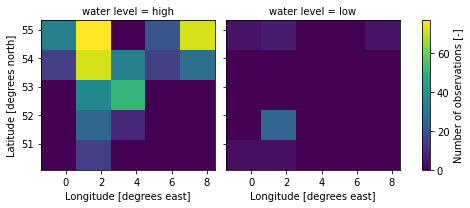

In [23]:
ss.plot('n');

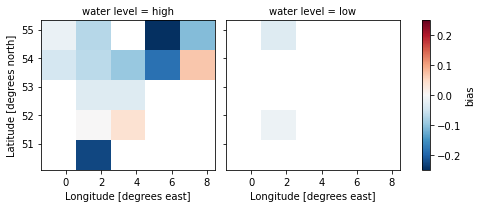

In [24]:
ss.plot('bias');

## Multiple observations

Add fake 2nd observation to model

In [25]:
df2 = df.copy()
df2['surface_elevation'] = df2['surface_elevation'] - 0.2
o2 = TrackObservation(df2, item=2, name='alti2')
con.add(o2, mr)

c:\users\jem\source\fmskill\fmskill\utils.py:38: UserWarning: Time axis has duplicate entries. Now adding milliseconds to non-unique entries to make index unique.
  warnings.warn(


Extract, spatial skill, add attrs, plot.

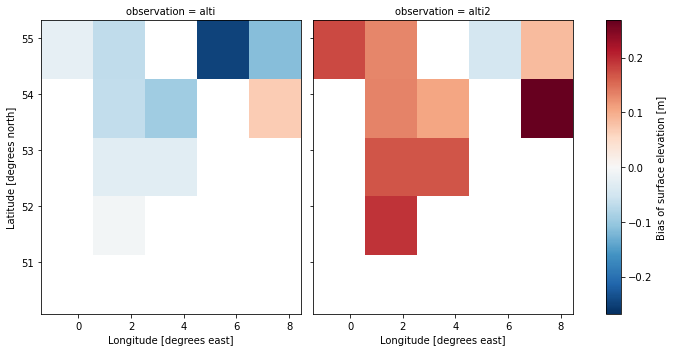

In [26]:
cc = con.extract()
ss = cc.spatial_skill(metrics=['bias'],n_min=20)
ss.ds['bias'].attrs = dict(long_name="Bias of surface elevation",units="m")
ss.plot('bias', figsize=(10,5));